# NLP, DS-поток
## Задание 3
### Transformers.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**
  * Работа с данными, токенизация, реализация метрики &mdash; 20 баллов;
  * Реализация модели &mdash; 20 баллов;
  * Реализация пайплайна &mdash; 60 баллов;
  * MLM &mdash; 50 баллов.


In [1]:
# Bot check

# HW_ID: ds_nlp3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install transformers
!pip install datasets
#!pip install torch==2.4.0
#!pip install torchvision==0.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00


In [1]:
import transformers

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)


### Описание задачи
В этом домашнем задании мы будем работать с данными с [соревнования](https://boosters.pro/championship/HeadHunter/overview) от HeadHunter. Нам предстоит предсказать причины которые закодированы числами от 1 до 8, по которым отзыв на работадателя не проходит модерацию. Причин, по которым отзыв не прошёл модерацию может быть несколько. Если отзыв проходит модерацию, то вместо причины отказа нужно предсказывать 0. Значение 0 разрешается комбинировать с причинами отказа.

Таким образом, мы имеем дело с задачей *multi-label классификации*.
Самый простой и популярный способ работать с multi-label задачей классификации &mdash; перейти к бинарной. Для каждого класса мы ставим метку 1, если он присутствует в таргете, а 0 &mdash; иначе. В процессе обучения мы будем минимизировать бинарную кросс-энтропию.

В качестве целевой метрики будем использовать $F_1$-score с усреднением по сэмплам.

$$
F_1 = \frac{1}{n}\sum_{i=1}^n 2\frac{precision_i recall_i}{precision_i + recall_i},
$$
где $n$ &mdash; размер выборки, а $precision_i, recall_i$ &mdash; precision/recall для i-го объекта.

### Работа с данными

Загрузите обучающий датасет.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/DS/6 sem/nlp/task 3/HeadHunter_train.csv")
data.head(5)

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


Как можно увидеть, помимо положительного `positive` и отрицательного `negative` текста отзывов, мы также имеем некоторое количество категориальных признаков, с которыми мы пока не будем работать. Целевая переменная расположена в колонке `target` и представляет из себя строку, разделенную запятыми.

Посмотрим, какие значения может принимать целевая переменная.

In [4]:
data["target"].unique()

array(['0', '8', '7', '1,8', '3,8', '6,8', '6', '3', '1', '1,6', '4,8',
       '5', '5,8', '1,5', '7,8', '4', '5,6', '1,4', '1,6,8', '1,7',
       '1,5,8', '1,3,8', '1,3', '1,4,6', '4,6', '1,3,5', '3,5,8', '1,5,6',
       '1,4,8', '1,2,6', '5,7', '3,5', '5,6,8', '1,3,6', '3,7', '2',
       '1,7,8', '3,6,8', '6,7', '4,6,8', '5,7,8', '3,6', '1,5,6,8',
       '3,5,7'], dtype=object)

Посмотрим на примеры отзывов, которые не прошли модерацию.

In [5]:
data[data["target"] == "5,8"]["positive"].values[13]

'Известная компания.....................................................................................................'

In [6]:
data[data["target"] == "3,8"]["positive"].values[29]

'Хужбвб влвлв в вщвлу у улыды ыыд'

Для дальнейшей работы избавьтесь от ненужных колонок, а также преобразуйте строковую целевую переменную в удобный для работы формат в виде матрицы, где каждому объекту будет сопоставлен вектор размерности 9, в котором на позиции $i$ будет стоять 1, если $i$ встречаетcя в текстовом поле `target`.



In [7]:
def target_to_vector(target_str):
    vector = np.zeros(9, dtype=int)
    indices = map(int, target_str.split(','))
    for index in indices:
        vector[index] = 1
    return vector

data["target"] = data["target"].apply(target_to_vector)

data

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...
50871,192815,Челябинск,"Техник-электрик, обслуживание зданий и сооруже...",Ни чего ни чего ни чего ни чего,Всё всё Всё всё Всё всё Всё всё Всё всё Всё всё,2,2,1,1,1,1,"[0, 0, 0, 1, 0, 0, 0, 0, 1]"
50872,192818,Санкт-Петербург,Старший специалист группы приёмки,Есть исключительно хорошие руководители.,Удачи хорошем управляющим в компании.,5,3,4,3,5,2,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
50873,192820,Нижний Новгород,Кладовщик,Уютная столовая .раздевалка,График работы. Обучение сотрудников,2,1,3,2,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
50874,192827,Москва,Инженер эксплуатации радиоподсистемы,"Не соблюдают трудовой кодекс, переработки 7 д...",Рабская эксплуатация работников,4,5,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"


Разделите выборку на обучающую и валидационную.

In [8]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=["target"])
labels = np.vstack(data["target"])

train_data, val_data, train_labels, val_labels = train_test_split(
    features, labels, test_size=0.2
)

### Токенизация и реализация метрики качества

Теперь реализуем вышеупомянутую метрику, а именно $F_1$-score с усреднением по сэмплам. Подумайте, как поступить, если для какого-то из объектов $precision=recall=0$?

In [9]:
def calculate_f1_score(preds, targets):
    """
    Функция подсчета F1-score с усреднением по сэмплам.

    :param preds: np.array размерности (n, 9), содержит в себе предсказания
                  в виде бинарной метки 0/1 для каждого класса
    :param preds: np.array размерности (n, 9), истинные бинарные таргеты
    """
    tp = np.sum(preds * targets, axis=1)
    fp = np.sum(preds * (1 - targets), axis=1)
    fn = np.sum((1 - preds) * targets, axis=1)

    precision = np.divide(tp, tp + fp, where=(tp + fp) > 0,
                      out=np.zeros_like(tp, dtype=float))
    recall = np.divide(tp, tp + fn, where=(tp + fn) > 0,
                   out=np.zeros_like(tp, dtype=float))


    f1_scores = np.divide(2 * precision * recall,
                          precision + recall,
                          where=(precision + recall) > 0,
                          out=np.zeros_like(precision, dtype=float))

    return np.mean(f1_scores)

В этом задании предлагается использовать библиотеку `transformers`, а значит позаботиться о токенизации надо заранее, ведь токенизаторы у разных моделей могут отличаться. Вы можете использовать любую модель, которая умеет работать с русским языком. Рекомендуем обратить внимания на следующие:

* [ruBert-base](https://huggingface.co/sberbank-ai/ruBert-base)
* [rubert-base-cased](https://huggingface.co/DeepPavlov/rubert-base-cased)
* [distilrubert-base-cased-conversational](https://huggingface.co/DeepPavlov/distilrubert-base-cased-conversational)
* [rubert-tiny](https://habr.com/ru/post/562064/)
* [ruRoberta-large](https://huggingface.co/sberbank-ai/ruRoberta-large/)

Учтите, что некоторые из моделей могут потребовать значительных ресурсов GPU. Для обучения рекомендуем использовать Colab или Kaggle. Самая легкая и быстрая модель из перечисленных &mdash; это `rubert-tiny`, можете для простоты использовать ее.

На вход модели предлагается подавать последовательность следующего вида: `[CLS] positive [SEP] negative [SEP]`, где `positive` и `negative` &mdash; тексты положительной и отрицательной части отзыва, разделенные спец. токеном `[SEP]`, получить который можно через `tokenizer.sep_token`. То есть мы сразу подаем в энкодер тексты обеих частей отзыва и пытаемся предсказать результат модерации. После применения энкодера скрытое состояние, соответствующее токену `[CLS]`, будет содержать информацию о содержании отзыва. После этого, просто используя линейный слой, мы сможем сделать предсказание для 9 классов.

In [10]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

# соединим две части отзыва
# токен CLS и второй SEP добавит токенизатор
train_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in train_data.iterrows()
]

val_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in val_data.iterrows()
]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Создадим датасет, используя `datasets.Dataset` и метод `.from_dict(...)`.

In [11]:
train_dataset = Dataset.from_dict({
    "text": train_concatenated,  # тексты
    "labels": train_labels       # метки
})

val_dataset = Dataset.from_dict({
    "text": val_concatenated,
    "labels": val_labels
})

<Figure size 1500x500 with 0 Axes>

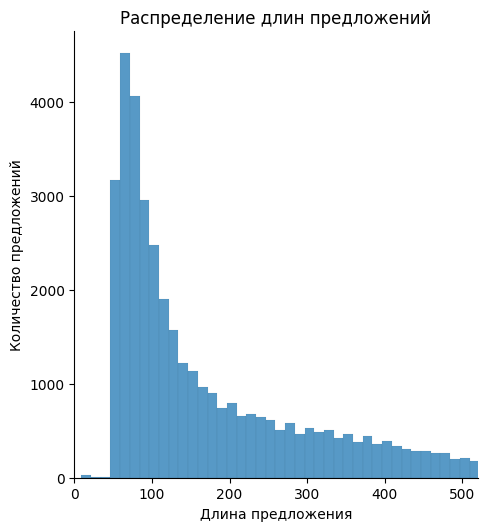

In [12]:
import seaborn as sns
import time
import matplotlib.pyplot as plt

lens = [len(x["text"]) for x in train_dataset]

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlim([0, 520])
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

Можно брать длину порядка 150

Наш датасет содержит тексты и метки к ним. Для дальнешей работы тексты нужно токенизировать, для этого воспользуемся методом `map` у датасета.

In [13]:
train_dataset = train_dataset.map(# применяем функцию к каждому элементу датасета
    lambda elem: tokenizer(
        elem["text"],             #  токенизируем поле text
        add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
        truncation=True,          #  обрезаем ли последовательность
        max_length=150            #  ограничение на длину, надо выставить разумно? :)
    )
)

val_dataset = val_dataset.map(
    lambda elem: tokenizer(
        elem["text"],
        add_special_tokens=True,
        truncation=True,
        max_length=150
    )
)

Map:   0%|          | 0/40700 [00:00<?, ? examples/s]

Map:   0%|          | 0/10176 [00:00<?, ? examples/s]

Посмотрим на элемент нашего датасета.

In [19]:
train_dataset[7]

{'text': 'ДМС, выплаты всегда вовремя, обучение, система менеджмента, коллектив, ты сам выбираешь , что ты будешь делать и в какой сфере, компания очень разнообразная во всех сферах (офис, ритейл, склад), всегда вкладывается в ребят и не жалеет денег.после закрытия для команды вызывают маршрутку , или такси.корпоративы, мероприятия.ты можешь выбирать магазин, где тебе удобно работать или путешествовать, реально даже работать в другой стране, очень мобильная компания. [SEP] Все очень круто, было бы прикольно, если бы были комплексные обеды , ну или бюджет для еды, транспорта.тогда была бы не работа, а мечта',
 'labels': [1, 0, 0, 0, 0, 0, 0, 0, 0],
 'input_ids': [2,
  284,
  6325,
  3330,
  16,
  26629,
  1231,
  14606,
  13157,
  815,
  21337,
  29046,
  16,
  18893,
  16,
  5155,
  2740,
  10138,
  1845,
  17875,
  16,
  25415,
  26150,
  16,
  23101,
  5599,
  26629,
  19711,
  10141,
  1090,
  16,
  1046,
  23101,
  9482,
  19319,
  7843,
  1348,
  320,
  314,
  22933,
  24709,
  16

Как видим, помимо `input_ids`, которые отправятся на вход модели, у нас так же имеется `attention_mask`, а также в зависимости от модели могут быть `token_type_ids` &mdash; некоторые модели используют для задачи **NSP**.

Вообще говоря, уже на этапе токенизации мы могли бы дополнить паддингом до максимальной длины наши последовательности, это можно сделать при вызове токенизатора, используя параметр `padding`. Однако у это подхода есть недостатки, поэтому эффективнее будет выполнить паддинг в даталоадере, на этапе формирования батча, тем самым дополнив все последовательности по длине до максимальной длины в батче.

Подробнее о токенизаторах в `transformers` можно почитать по [ссылке](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer).

Посмотрим, как расположены спец токены:

In [20]:
tokenizer.decode(train_dataset[6]["input_ids"])

'[CLS] Всю сознательную жизнь работаю в продажах, поэтому выйти на хорошую заработную плату мне удалось быстро. В Соколове работаю около года и понимаю, что здесь созданы все условия, для того чтобы продавцы зарабатывали : стабильно процент с продаж, премии и другая мотивация. Есть обучение. В коллектив влиться тоже оказалось легко. За все время работы у меня не было ни одного конфликта. [SEP] Наверное ничего. [SEP]'

Избавимся от теперь ненужного поля `text`.

In [21]:
train_dataset = train_dataset.remove_columns("text")
val_dataset = val_dataset.remove_columns("text")

### Модель

Реализуйте класс модели. В качестве классификатора используйте линейный слой, в который можно подать, например, эмбеддинг CLS-токена с последнего слоя, который можно получить следующим образом:



```
output = bert(input)
cls_token = output.last_hidden_state[:, 0, :]
logits = classifier(cls_token)
```



In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
        self.fc = nn.Linear(self.model.config.hidden_size, 9)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        output = self.model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
        )
        # возьмем CLS токен
        output = output.last_hidden_state[:, 0, :]
        output = self.fc(output)

        if labels is not None:
            labels = labels.float()
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(output, labels)

        return (loss, output) if labels is not None else output

Проверьте работоспособность модели простым тестом на размерность. В зависимости от реализации метода forward, код ниже стоит поменять, сохранив смысл.

In [15]:
batch_size = 8
dummy_input = {"input_ids" : torch.randint(0, 20000, (batch_size, 256)),
               "attention_mask":  torch.randint(0, 20000, (batch_size, 256))}
model = Model()

assert model(dummy_input["input_ids"], dummy_input["attention_mask"]).shape == (batch_size, 9)

### Пайплайн обучения

1. Реализуйте пайплайн обучения и обучите модель. Попробуйте по желанию воспользоваться `Trainer`-ом и библиотеки `transformers`. Вам могут помочь примеры [здесь](https://huggingface.co/docs/transformers/training), [здесь](https://huggingface.co/learn/nlp-course/chapter3/3) и [здесь](https://github.com/huggingface/transformers/tree/main/examples/pytorch/text-classification). Учтите, что у нас задача *multi-label классификации*, которую мы свели к бинарной классификации нескольких меток, а значит нужно использовать **BCE-loss**.
2. Cначала обучите только последний линейный слой, заморозив веса языковой модели, а затем всю модель целиком. Посчитайте качество на валидационной выборке и сравните результаты.

Подумайте, как стоит выбирать порог для бинарной классификации. Что делать, если мы не предсказали никакой класс? Что можно сказать о результатах?



В случае использования `transformers.Trainer` в него можно передать датасеты, а также `data collator` &mdash; объект, который непосредственно формирует батч по списку объектов из датасета. Обычно, в процессе формирования батча `data collator` может выполнять некоторой препроцессинг, например, паддинг или маскирование токенов в задаче **MLM**.

Воспользуемся простым data collator-ом для паддинга наших текстов. Создадим даталоадеры для случая самописного кода обучения.

In [16]:
data_collator = DataCollatorWithPadding(tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=data_collator)

val_loader = DataLoader(val_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          collate_fn=data_collator)

Посмотрим на батч данных.

In [49]:
next(iter(train_loader))

{'labels': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]]), 'input_ids': tensor([[    2,   281,  1044,  ...,     0,     0,     0],
        [    2,   282, 11143,  ..., 21523,   320,     3],
        [    2,  5386,  1044,  ...,     0,     0,     0],
        ...,
        [    2,    18,    18,  ...,     0,     0,     0],
        [    2,  7644, 10658,  ...,     0,     0,     0],
        [    2,   299, 24716,  ...,     0,     0,     0]]), 'token_type_ids': t

Сначала замораживаем слои

In [53]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits).to("cpu")) > 0.5).numpy()
    return {"f1_score": calculate_f1_score(preds, labels)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.model.parameters():
    param.requires_grad = False  # Замораживаем все кроме последнего слоя

training_args = TrainingArguments(
    output_dir="./results", per_device_train_batch_size=16, per_device_eval_batch_size=16,
    evaluation_strategy="epoch", save_strategy="epoch", num_train_epochs=3,
    logging_dir="./logs", logging_steps=500, load_best_model_at_end=True
)


trainer = Trainer(
    model=model, args=training_args,
    train_dataset=train_dataset, eval_dataset=val_dataset,
    tokenizer=tokenizer, data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-53-a76630058d03>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.179000,0.173757,0.710774
2,0.157000,0.157285,0.720961
3,0.152400,0.154470,0.724335


TrainOutput(global_step=7632, training_loss=0.19627099891878524, metrics={'train_runtime': 128.8045, 'train_samples_per_second': 947.948, 'train_steps_per_second': 59.253, 'total_flos': 0.0, 'train_loss': 0.19627099891878524, 'epoch': 3.0})

Дообучим без заморозки

In [54]:
for param in model.model.parameters():
    param.requires_grad = True

model.to(device)
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Score
1,0.148500,0.147803,0.735833
2,0.145100,0.145646,0.738011
3,0.143000,0.145030,0.739518


TrainOutput(global_step=7632, training_loss=0.14797358567859642, metrics={'train_runtime': 235.6979, 'train_samples_per_second': 518.036, 'train_steps_per_second': 32.38, 'total_flos': 0.0, 'train_loss': 0.14797358567859642, 'epoch': 3.0})

Уже очень приличный F1 скор в 0.739!

### MLM pretraining

Попробуйте улучшить качество, предварительно обучив выбранную модель на задачу **MLM** на обучающем датасете. Будет достаточно 1-2 эпох. Воспользуйтесь [примерами](https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling) из репозитория. Правильно организовав файл с обучающими данными, остается лишь воспользоваться готовым скриптом.

In [17]:
file_path = 'train_concatenated.txt'

with open(file_path, 'w', encoding='utf-8') as file:
    for line in train_concatenated:
        file.write(line + '\n')

Запустим скрипт

In [19]:
!python '/content/drive/MyDrive/DS/6 sem/nlp/task 3/run_mlm.py' \
  --model_name_or_path=cointegrated/rubert-tiny \
  --train_file=train_concatenated.txt \
  --per_device_train_batch_size 8 \
  --per_device_eval_batch_size 8 \
  --do_train \
  --output_dir '/content/drive/MyDrive/DS/6 sem/nlp/task 3/mlm'

2025-03-19 15:08:17.013321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742396897.048016   16215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742396897.058842   16215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
03/19/2025 15:08:23 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
03/19/2025 15:08:23 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured

Обучите модель, полученную после процедуры **MLM** претрейна. Улучшилось ли качество?

In [22]:
!ls "/content/drive/MyDrive/DS/6 sem/nlp/task 3/mlm/checkpoint-2058"

config.json	   rng_state.pth	    tokenizer_config.json  training_args.bin
model.safetensors  scheduler.pt		    tokenizer.json	   vocab.txt
optimizer.pt	   special_tokens_map.json  trainer_state.json


In [24]:
model = Model()
model.model = AutoModel.from_pretrained("/content/drive/MyDrive/DS/6 sem/nlp/task 3/mlm/checkpoint-2058")

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/DS/6 sem/nlp/task 3/mlm/checkpoint-2058 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Теперь обучение с заморозкой

In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits).to("cpu")) > 0.5).numpy()
    return {"f1_score": calculate_f1_score(preds, labels)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.model.parameters():
    param.requires_grad = False

training_args = TrainingArguments(
    output_dir="./results", per_device_train_batch_size=16, per_device_eval_batch_size=16,
    evaluation_strategy="epoch", save_strategy="epoch", num_train_epochs=3,
    logging_dir="./logs", logging_steps=500, load_best_model_at_end=True
)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=train_dataset, eval_dataset=val_dataset,
    tokenizer=tokenizer, data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1612: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-3a4db8e85887>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ermolaevfedor (juequ) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Score
1,0.169800,0.167183,0.729936
2,0.160400,0.155106,0.735521
3,0.154500,0.152801,0.737569


TrainOutput(global_step=7632, training_loss=0.19034991199365453, metrics={'train_runtime': 131.0554, 'train_samples_per_second': 931.667, 'train_steps_per_second': 58.235, 'total_flos': 0.0, 'train_loss': 0.19034991199365453, 'epoch': 3.0})

И дообучение без заморозки

In [26]:
for param in model.model.parameters():
    param.requires_grad = True

model.to(device)
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Score
1,0.146300,0.146999,0.747232
2,0.149300,0.145143,0.748329
3,0.146600,0.144564,0.749378


TrainOutput(global_step=7632, training_loss=0.15078199409588827, metrics={'train_runtime': 236.3162, 'train_samples_per_second': 516.681, 'train_steps_per_second': 32.296, 'total_flos': 0.0, 'train_loss': 0.15078199409588827, 'epoch': 3.0})

Действительно, F1 score улучшился (0.739->0.749), что и ожидалось. Модель больше вытаскивает информации из данных, потому что была затюнина должным образом

[Здесь](https://habr.com/ru/company/alfa/blog/669522/) можно прочитать подход от участников, занявших второе место в этом соревновании.